In [1]:
# This script classifies gaze of participant into: looking at another participant, looking away, or in transition

# To do this, head rotation speed and gaze angle analysis are required (calculated with c++ analysis component)

In [2]:
import re
import matplotlib.pyplot as plt
from enum import Enum

In [3]:
#define location of data to visualize

# data_dir="C:/Users/gary4/Documents/repos/Recording-And-Analysis-Plugin/Data/group0"
# data_dir="Z:/Gary/Research/APlausE-MR_MR4_CollaborativeTelepresenceStudy/gazeAnalysis/group0"
data_dir="Z:/builds/aplause-mr/UNITY_APP/aplause-mr-20240707-studystate-v1/gazeAnalysis"

file_name="aplausemr_group0_date20240708_10_42_trial0_experimentcontroller_quantitative_requests_results.csv"



file_path = data_dir + "/" + file_name

In [4]:
cols = ['#EE204D', '#1CAC78', '#1F75FE', '#FCE883']


In [5]:
# define some data structures for reading data

class HeadRotationResults:
    def __init__(self, desc):
        self.times = []
        self.values = []
        
        # find participant ID for gazer
        participant_label_ends = [m.end() for m in re.finditer('Participant', desc)]
        self.gazer = int(desc[participant_label_ends[0]])
        
    def add_value(self,time,value):
        self.times.append(time)
        self.values.append(value)
        
class AngularDistanceResults:
    def __init__(self, desc):
        self.times = []
        self.values = []
        
        # find participant numbers for gazer and gaze target
        participant_label_ends = [m.end() for m in re.finditer('Participant', desc)]
        self.gazer = int(desc[participant_label_ends[0]])
        self.gaze_target = int(desc[participant_label_ends[1]])
        
    def trial_length(self):
        return self.times[-1]
        
    def add_value(self,time,value):
        self.times.append(time)
        self.values.append(value)
        
def get_value_at_time(obj, t):
    val = 0.0
    idx = 0
    
    while idx < len(obj.times) and obj.times[idx] < t:
        idx += 1
    
    if 0 == idx:
        return obj.values[0]
    elif idx == len(obj.times):
        return obj.values[-1]
    else:
        t1 = obj.times[idx - 1]
        t2 = obj.times[idx]
        v1 = obj.values[idx - 1]
        v2 = obj.values[idx]
        return v1 + (v2 - v1) * (t - t1) / (t2 - t1);

    
    

In [6]:
# read data into structures

rotation_streams = []
ang_distance_streams = []

f = open(file_path, "r")

reading_rot_stream = False

while True:
    line = f.readline()
    if not line:
        break

    if line.startswith("AnalysisQuery"):
        if "RotationAnalysis" in line:
            rotation_streams.append(HeadRotationResults(line))
            reading_rot_stream = True
        elif "GazeAnalysis" in line:
            ang_distance_streams.append(AngularDistanceResults(line))
            reading_rot_stream = False
        else:
            raise RuntimeError("Quantitative Analysis type not found")
            
    elif line.startswith('Time') or not line.strip():
        pass
    
    else:
        interval = line.split(',')

        if reading_rot_stream:
            rotation_streams[-1].add_value(float(interval[0]), float(interval[1]))
        else:
            ang_distance_streams[-1].add_value(float(interval[0]), float(interval[1]))

f.close()

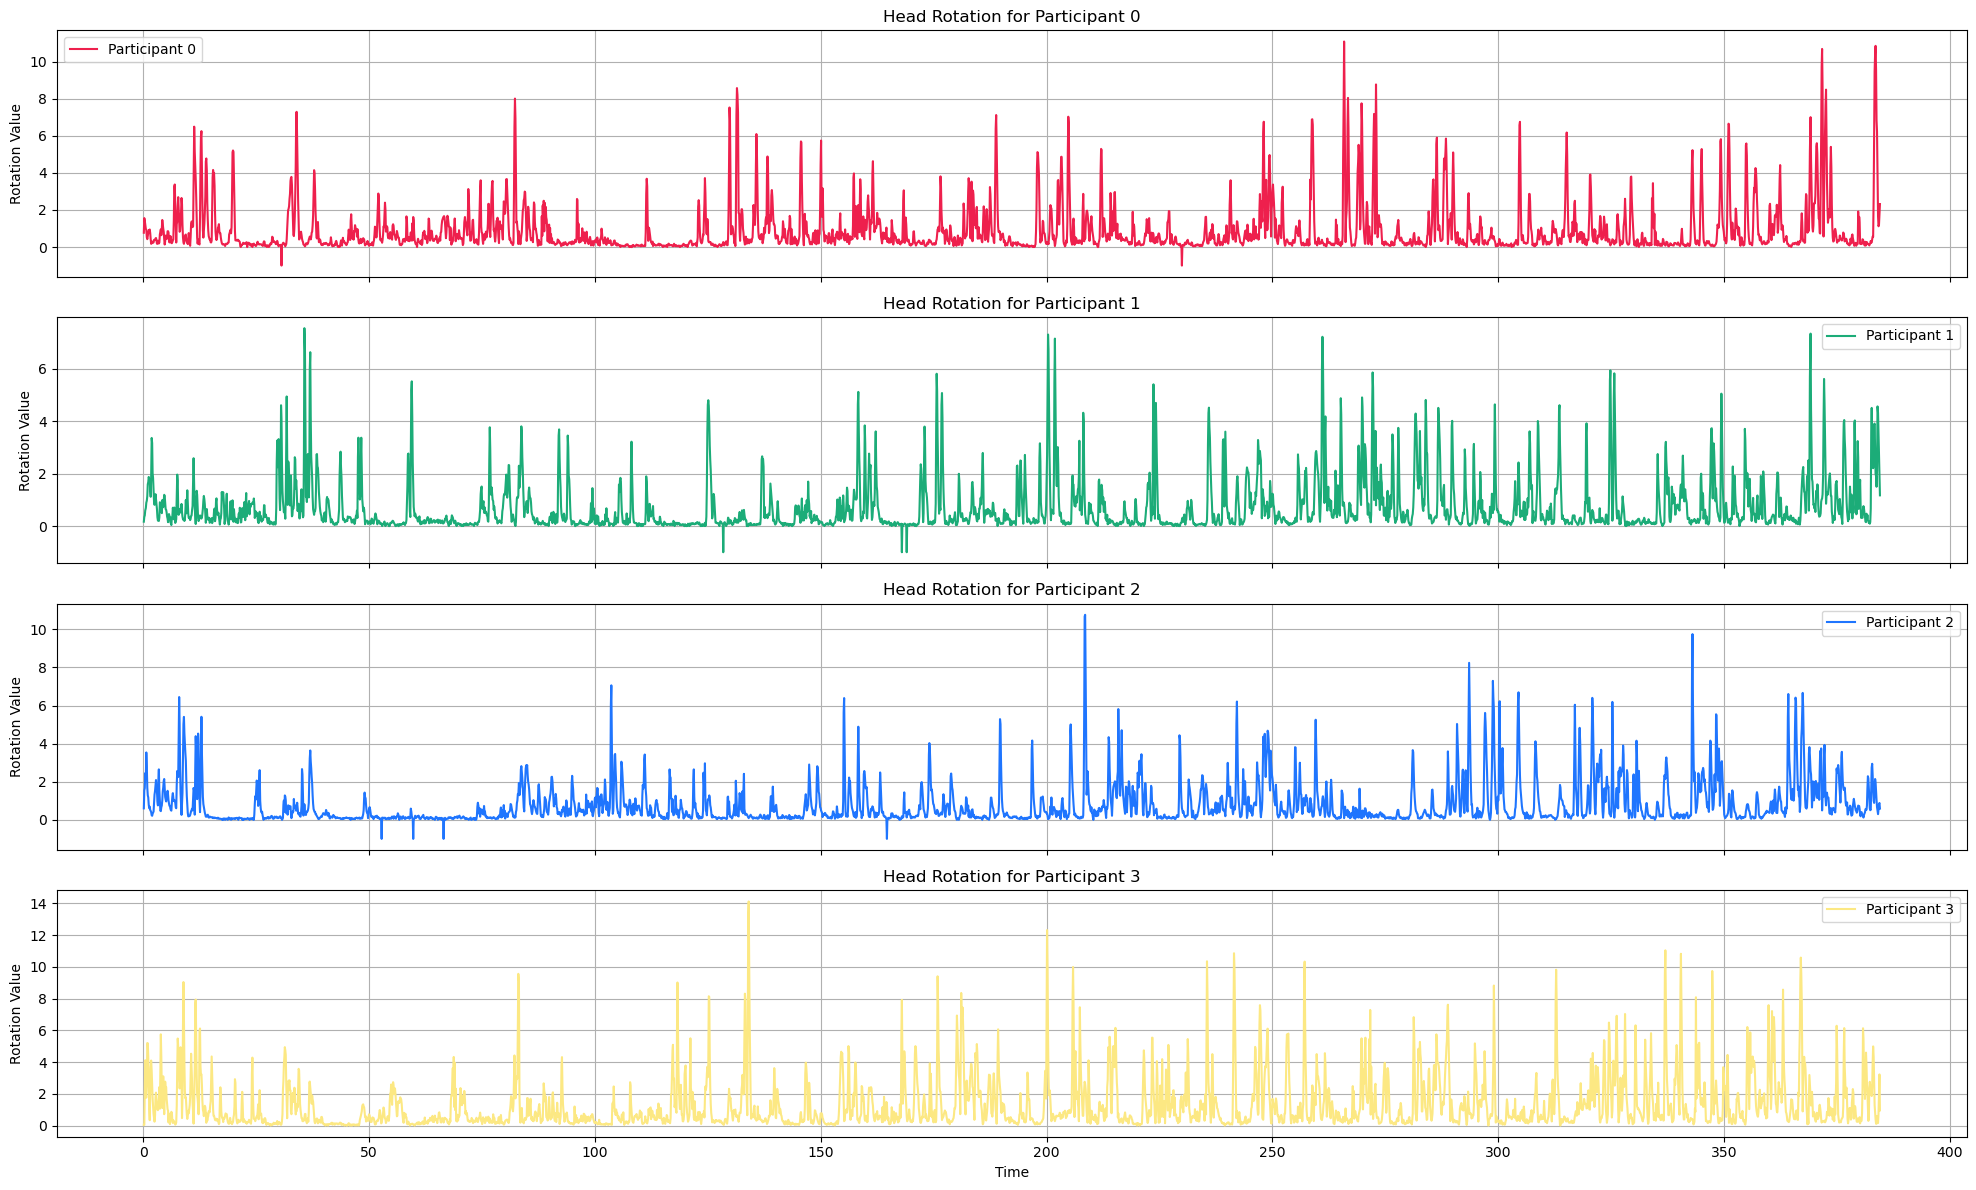

In [7]:
# Function to plot multiple HeadRotationResults on different line graphs

def plot_head_rotation_results(results_list):
    num_plots = len(results_list)
    
    # Create subplots
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, num_plots * 3), sharex=True)
    
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one subplot

    lines = 0
    # Plot each HeadRotationResults on a different line graph
    for ax, results in zip(axes, results_list):
        ax.plot(results.times, results.values, label=f'Participant {results.gazer}', color=cols[lines])
        lines += 1
        ax.set_title(f'Head Rotation for Participant {results.gazer}')
        ax.set_ylabel('Rotation Value')
        ax.legend()
        ax.grid(True)
    
    # Set common x-label
    plt.xlabel('Time')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
plot_head_rotation_results(rotation_streams)

In [8]:
# Function to plot multiple angular distance streams on different line graphs

def plot_angular_distance_results(results_list):
    num_plots = len(results_list)
    
    # Create subplots
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, num_plots * 3), sharex=True)
    
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one subplot

    # Plot each HeadRotationResults on a different line graph
    for ax, results in zip(axes, results_list):
        ax.plot(results.times, results.values, label=f'Participant {results.gazer}', color=cols[results.gazer])
        ax.set_title(f'Angular Distance for Participant {results.gazer} from Participant {results.gaze_target}')
        ax.set_ylabel('Angular Distance')
        ax.legend()
        ax.grid(True)
    
    # Set common x-label
    plt.xlabel('Time')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()

# plot_angular_distance_results(ang_distance_streams)

In [9]:
sample_rate = 10.0
sample_interval = 1 / sample_rate

ROTATION_THRESHOLD = 3.0
ANGLE_THRESHOLD = 25.0

In [10]:
class GazeState(Enum):
    TRANSITION = 0
    LOCAL = 1
    REMOTE_ADJACENT = 2
    REMOTE_OPPOSITE = 3
    AVERTED = 4


In [11]:
class GazeClassification:

    def __init__(self, gazer):
        self.times = []
        self.values = []
        self.gazer = gazer
        
    def add_value(self,time,value):
        self.times.append(time)
        self.values.append(value)

def GetGazeStateFromGazerAndTarget(gazer, gaze_target):
    if gazer == gaze_target:
        raise RuntimeError("gazer and target cannot be the same")
    if (gazer + gaze_target) % 2 == 0:
        return GazeState.REMOTE_OPPOSITE
    if int(gazer / 2) == int(gaze_target / 2):
        return GazeState.LOCAL
    
    return GazeState.REMOTE_ADJACENT


def ClassifyGaze(gazer):
    
    
    gazer_rot_streams = [r for r in rotation_streams if r.gazer == gazer] 
    if len(gazer_rot_streams) > 1:
        raise RuntimeError("Multiple rotation streams for gazer found")
    
    gazer_ang_distance_streams = [a for a in ang_distance_streams if a.gazer == gazer]
    if len(gazer_ang_distance_streams) != 3:
        raise RuntimeError("Wrong number of angular distance streams for gazer found")
    
    classification = GazeClassification(gazer)
    
    t = 0.0
    while t < trial_length:
        
        # do classification
        # check rotation is below threshold (otherwise this is a transition)
        state = GazeState.TRANSITION
        rot_at_t = get_value_at_time(gazer_rot_streams[0], t)
        if rot_at_t < ROTATION_THRESHOLD:
            
            # find best angle (if any below threshold)
            state = GazeState.AVERTED
            gaze_target = -1
            best_angle = 180
            
            for stream in gazer_ang_distance_streams:
                angle = get_value_at_time(stream, t)
                if angle < ANGLE_THRESHOLD and angle < best_angle:
                    best_angle = angle
                    gaze_target = stream.gaze_target
                
            # determine state if gaze not averted
            if gaze_target != -1:
                state = GetGazeStateFromGazerAndTarget(gazer, gaze_target)
        
        classification.add_value(t,state)
        t += sample_interval
    
    return classification

# get length of trial
trial_length = max([r.trial_length() for r in ang_distance_streams])
    
classifications = []
for p in range(4):
    classifications.append(ClassifyGaze(p))

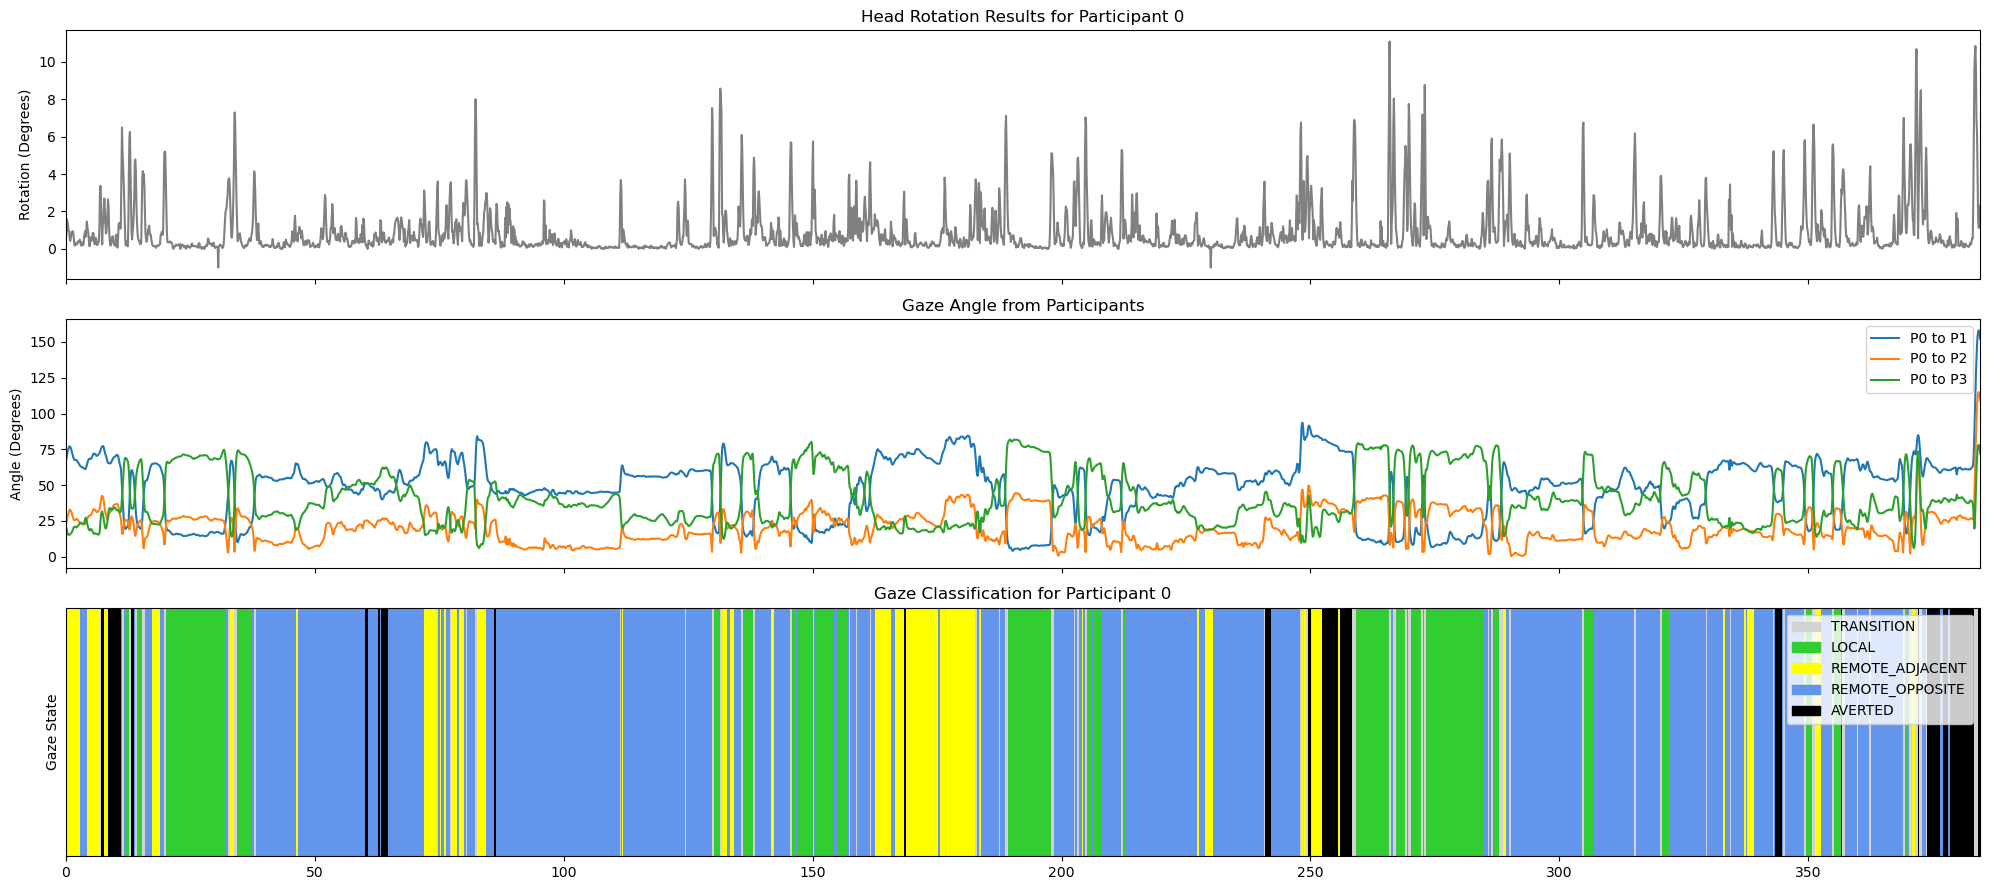

In [12]:
# Define colors for each GazeState
gaze_state_colors = {
    GazeState.TRANSITION: 'lightgray',
    GazeState.LOCAL: 'limegreen',
    GazeState.REMOTE_ADJACENT: 'yellow',
    GazeState.REMOTE_OPPOSITE: 'cornflowerblue',
    GazeState.AVERTED: 'black',
}

def PlotClassificationResultsForGazer(gazer):
    
    hrs = [r for r in rotation_streams if r.gazer == gazer] 
    head_rotation = hrs[0] 

    ads = [a for a in ang_distance_streams if a.gazer == gazer]
    angular_distance_1 = ads[0]
    angular_distance_2 = ads[1]
    angular_distance_3 = ads[2]

    gaze_classification = classifications[gazer]

    # Convert GazeClassification data to segments
    segments = []
    for i in range(len(gaze_classification.times) - 1):
        start_time = gaze_classification.times[i]
        duration = gaze_classification.times[i + 1] - start_time
        gaze_state = gaze_classification.values[i]
        segments.append((start_time, duration, gaze_state))


    # Create a figure and a set of subplots
    fig, axs = plt.subplots(3, 1, figsize=(20, 9), sharex=True)

    # Plot Head Rotation Results
    axs[0].plot(head_rotation.times, head_rotation.values, color='gray')
    axs[0].set_title(f'Head Rotation Results for Participant {head_rotation.gazer}')
    axs[0].set_ylabel('Rotation (Degrees)')

    for ad in range(3):
        # Plot Angular Distance Results
        axs[1].plot(ads[ad].times, ads[ad].values, label=f'P{ads[ad].gazer} to P{ads[ad].gaze_target}')
    axs[1].set_title("Gaze Angle from Participants")
    axs[1].set_ylabel('Angle (Degrees)')
    axs[1].legend()

    # Plot Gaze Classification as a horizontal bar
    for segment in segments:
        axs[2].broken_barh([(segment[0], segment[1])], (0, 1), facecolors=gaze_state_colors[GazeState(segment[2])])

    axs[2].set_title(f'Gaze Classification for Participant {gaze_classification.gazer}')
    axs[2].set_yticks([])
    axs[2].set_yticklabels([])
    axs[2].set_ylim(0, 1)
    axs[2].set_xlim(0, gaze_classification.times[-1])
    axs[2].set_ylabel('Gaze State')

    # Add a color legend for the gaze states
    legend_patches = [plt.Rectangle((0,0),1,1, color=gaze_state_colors[state]) for state in GazeState]
    axs[2].legend(legend_patches, [state.name for state in GazeState], loc='upper right')

    # Final adjustmentst
    plt.tight_layout()
    plt.show()

PlotClassificationResultsForGazer(0)

In [13]:

def WriteResults(classification_results_all_ps):
    out_file_path = file_path.replace("quantitative_requests_results", "gaze_classification_results")
    
    with open(out_file_path, "w") as file:
        for r in classification_results_all_ps:
            file.write("AnalysisQuery,GazeClassification Participant" + str(r.gazer) + "\n")
            file.write("RotationThreshold," + str(ROTATION_THRESHOLD) + "\n")
            file.write("AngleThreshold," + str(ANGLE_THRESHOLD) + "\n")
            file.write("Time,State\n")
            for t, state in zip(r.times, r.values):
                file.write(str(t) + "," + str(state.value) + "\n")
              
        
WriteResults(classifications)
